<a href="https://colab.research.google.com/github/scumulder/Machine-Learning-Spring-2019-UCF/blob/master/Homework%203/3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 3

Working with the **Cats vs Dogs** data set and the pretrained convnet VGG19:

*  Visualize heatmaps of class activation for the the model obtained in Problem 2.


**Download the Data:**

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-17 07:58:28--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   202MB/s    in 0.3s    

2019-04-17 07:58:28 (202 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Build network with VGG19 convolution base and custom densely connected layers:

In [4]:
from keras.applications import VGG19

base_model = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))
#base_model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


**Add the dense layers:**

In [5]:
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K

# network = models.Sequential()
# network.add(base_model)
# network.add(layers.Flatten())
# network.add(layers.Dense(256, activation='relu'))
# network.add(layers.Dense(1, activation='sigmoid'))

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)


# this is the model we will train
network = models.Model(inputs=base_model.input, outputs=predictions)

network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

**Augment the Data:**

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**Fine-tune the data:**

In [7]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


**Compile and train the network:**

In [8]:
# Compile the network

network.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# Train the network

history = network.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
100/100 [==============================] - 25s 245ms/step - loss: 0.5553 - acc: 0.7225 - val_loss: 0.3699 - val_acc: 0.8470
Epoch 2/15
100/100 [==============================] - 19s 191ms/step - loss: 0.3859 - acc: 0.8340 - val_loss: 0.3066 - val_acc: 0.8690
Epoch 3/15
100/100 [==============================] - 19s 191ms/step - loss: 0.3190 - acc: 0.8685 - val_loss: 0.2706 - val_acc: 0.8810
Epoch 4/15
100/100 [==============================] - 19s 190ms/step - loss: 0.3009 - acc: 0.8715 - val_loss: 0.2377 - val_acc: 0.8920
Epoch 5/15
100/100 [==============================] - 20s 197ms/step - loss: 0.2834 - acc: 0.8830 - val_loss: 0.2168 - val_acc: 0.9070
Epoch 6/15
100/100 [==============================] - 19s 194ms/step - loss: 0.2587 - acc: 0.8920 - val_loss: 0.1962 - val_acc: 0.9160
Epoch 7/15
100/100 [==============================] - 19s 191ms/step - loss: 0.2471 - acc: 0.9000 - val_loss: 0.1889 - val_acc: 0.9160
Epoch 8

**Evalutate the network using the validation data:**

In [9]:
val_loss, val_acc = network.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", round(val_acc*100,2), "%")

Validation loss: 0.20853244826197626
Validation accuracy: 91.3 %


## Generate Class Activation Maps:

In [0]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions

img_path1 = '/tmp/cats_and_dogs_filtered/validation/cats/cat.2493.jpg'
img_path2 = '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2167.jpg'

In [0]:
last_conv_layer = base_model.get_layer('block5_conv4')

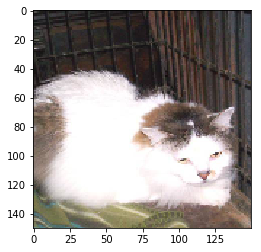

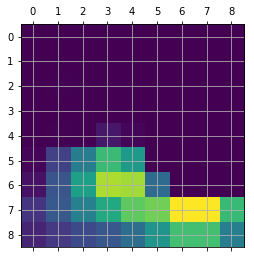

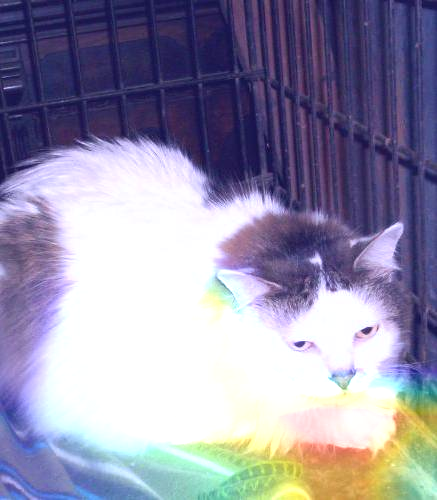

In [20]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K


def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  cv2_imshow(superimposed_img)
 
  
def process_image(img_path, idx=0):
  img = image.load_img(img_path, target_size=(150,150))
  
  plt.imshow(img)
  plt.show()
 
  y = image.img_to_array(img)
  y = np.expand_dims(y, axis=0)
  y = preprocess_input(y)
  
  preds = network.predict(y)
#   print("Preds: ", preds)
  
  class_index = np.argsort(preds[0])[-(1+idx)]
#   print("Class index: ", class_index)
  class_output = network.output[:, class_index]
#   print("Class output: ", class_output)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
#   print("Grads: ", grads)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
#   print("Pooled grads: ", pooled_grads)
  iterate = K.function([network.input], [pooled_grads, last_conv_layer.output[0]])
#   print("Iterate: ", iterate)
  pooled_grads_value, conv_layer_output_value = iterate([y])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    
#   print(conv_layer_output_value)
  heatmap = np.mean(conv_layer_output_value, axis=-1)
#   print("Heatmap: ", heatmap)
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  
  show_superimposed_image(img_path, heatmap)
  
process_image(img_path1)
# process_image(img_path2)